Problem Statement

What is the best location for Italian cuisine in New York City?

In what Neighborhood and borough should the investor open a Italian restaurant to have the best chance of being successful?

Where would I go in New York City to have the best Italian food?

In [17]:
#import required libraries

import numpy as np
import pandas as pd

import requests
import os

import folium

from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns


In [18]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Defing the Functions that are going to be used in this project

In [19]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [20]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [21]:
ny_data.shape

(306, 4)

Initial data analysis

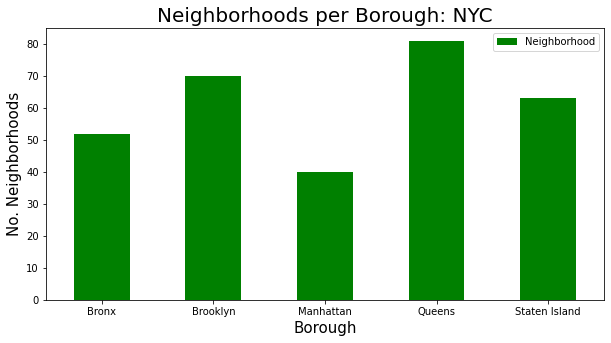

In [22]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [23]:
# queens has most neighborhoods
# prepare neighborhood list that contains italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    print(row)
    for resturant_detail in italian_restaurants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
['

( 68 / 306 ) Italian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Italian Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Italian Restaurants in Fort Greene, Brooklyn:4
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Italian Restaurants in Park Slope, Brooklyn:2
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Italian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Italian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Italian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Italian Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269

( 131 / 306 ) Italian Restaurants in Woodside, Queens:0
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Italian Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Italian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Italian Restaurants in Howard Beach, Queens:3
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Italian Restaurants in Corona, Queens:1
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Italian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Italian Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Italian Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) I

( 198 / 306 ) Italian Restaurants in St. George, Staten Island:2
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Italian Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Italian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Italian Restaurants in Rosebank, Staten Island:1
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Italian Restaurants in West Brighton, Staten Island:2
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Italian Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Italian Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Italian Restaurants in South Bea

( 259 / 306 ) Italian Restaurants in Elm Park, Staten Island:0
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Italian Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Italian Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Italian Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Italian Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Italian Restaurants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Italian Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Italian Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120

In [24]:
italian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
228,Queens,Sunnyside Gardens,5699aa86498ef437b2fd7102,Zio Luigi
229,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
230,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
231,Staten Island,Prince's Bay,4c091311a1b32d7f5efb96f0,Certo's Gourmet Foods & Caterers
232,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


There are about 229 italian restaurants across New York city.

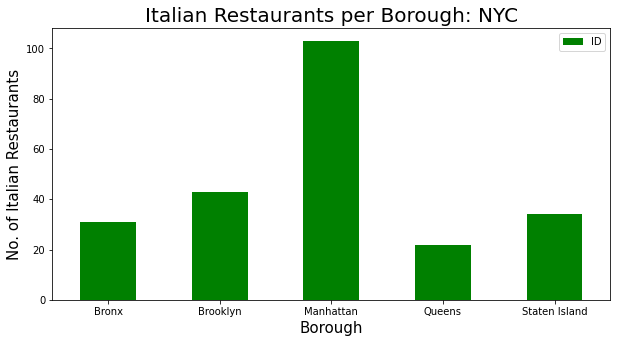

In [25]:
#Italian restaurants per borough
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Manhattan is having the highest number of Italian restaurants despite of having less number of neighborhoods.

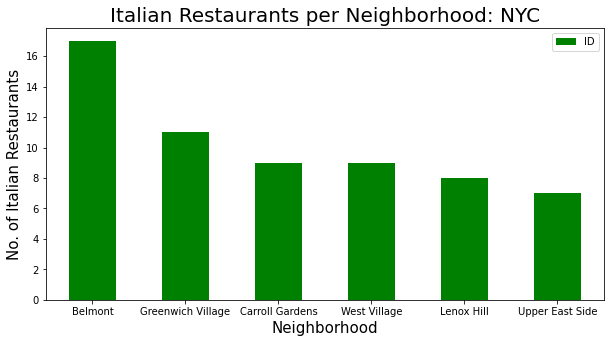

In [26]:
NoOfNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NoOfNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [27]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
8,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
9,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
10,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
11,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
12,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
13,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
14,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
15,Bronx,Belmont,4c9b9e7b9c663704b90463fd,Gerbasi Ristorante
16,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
17,Bronx,Belmont,4bc22a22920eb713bcc51b2c,Tra Di Noi


Belmont has the highest number of italian restaurants with a total count of 17.
Now we will get the ranking of each restaurant for further analysis.

In [28]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '611281f03f0278275a14668b'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}, {'label': 'entrance', 'lat': 40.900601, 'lng': -73.867611}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '611281f101f9a50b6dc237aa'}, 'response': {'venue': {'id': '4bf96ae65317a593d837017f', 'name': "Enzo's", 'contact': {'phone': '7184093828', 'formattedPhone': '(718) 409-3828'}, 'location': {'address': '1998 Williamsbridge Rd', 'lat': 40.854232311821725, 'lng': -73.85436243306151, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854232311821725, 'lng': -73.85436243306151}, {'label': 'entrance', 'lat': 40.854116, 'lng': -73.854132}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1998 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/enzos/4bf96ae65317a593d837017f', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '611281f1c0d86c47f59ee33f'}, 'response': {'venue': {'id': '4b47f069f964a5208c4426e3', 'name': 'Pasta Pasta', 'contact': {'phone': '7188929634', 'formattedPhone': '(718) 892-9634'}, 'location': {'address': '2023 Williamsbridge Rd', 'lat': 40.85478806485715, 'lng': -73.85492881053774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85478806485715, 'lng': -73.85492881053774}, {'label': 'entrance', 'lat': 40.854792, 'lng': -73.855184}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2023 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasta-pasta/4b47f069f964a5208c4426e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '611281f3368b16337cbd6c35'}, 'response': {'venue': {'id': '4b1712a8f964a520dbc123e3', 'name': 'Jolly Tinker', 'contact': {'phone': '3477265644', 'formattedPhone': '(347) 726-5644'}, 'location': {'address': '2875 Webster Ave', 'lat': 40.86745127461597, 'lng': -73.88353583600046, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86745127461597, 'lng': -73.88353583600046}, {'label': 'entrance', 'lat': 40.867508, 'lng': -73.883501}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2875 Webster Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jolly-tinker/4b1712a8f964a520dbc123e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d4898

{'meta': {'code': 200, 'requestId': '611281f35747d24b47407853'}, 'response': {'venue': {'id': '4be35e62b02ec9b6b66b4fc0', 'name': "Vibano's", 'contact': {}, 'location': {'address': '3202 Ampere Ave', 'lat': 40.846025, 'lng': -73.82097399999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.846025, 'lng': -73.82097399999999}, {'label': 'entrance', 'lat': 40.846152, 'lng': -73.820944}], 'postalCode': '10465', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3202 Ampere Ave', 'Bronx, NY 10465', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vibanos/4be35e62b02ec9b6b66b4fc0', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'

{'meta': {'code': 200, 'requestId': '611281f3863ab62d3b3b3e13'}, 'response': {'venue': {'id': '4acf80aef964a52025d420e3', 'name': "Tino's Delicatessen", 'contact': {'phone': '7187339879', 'formattedPhone': '(718) 733-9879'}, 'location': {'address': '2410 Arthur Ave', 'crossStreet': 'E. 187 St.', 'lat': 40.85588217093613, 'lng': -73.88716612015719, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85588217093613, 'lng': -73.88716612015719}, {'label': 'entrance', 'lat': 40.855816, 'lng': -73.887189}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2410 Arthur Ave (E. 187 St.)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tinos-delicatessen/4acf80aef964a52025d420e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suff

{'meta': {'code': 200, 'requestId': '611281f48acfb5676fc56e71'}, 'response': {'venue': {'id': '4af71916f964a520cf0522e3', 'name': "Michaelangelo's Coal Fired Brick Oven Pizza Restaurant", 'contact': {'phone': '3475907650', 'formattedPhone': '(347) 590-7650'}, 'location': {'address': '2477 Arthur Ave', 'lat': 40.85741189614754, 'lng': -73.88646821282298, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85741189614754, 'lng': -73.88646821282298}, {'label': 'entrance', 'lat': 40.857301, 'lng': -73.886231}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2477 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michaelangelos-coal-fired-brick-oven-pizza-restaurant/4af71916f964a520cf0522e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categor

{'meta': {'code': 200, 'requestId': '611281f41ef2533f0f449cd0'}, 'response': {'venue': {'id': '59050f51b23dfa5f6649e678', 'name': 'Arthur Avenue Fiasco', 'contact': {'phone': '7186180806', 'formattedPhone': '(718) 618-0806'}, 'location': {'address': '2376 Arthur Ave', 'crossStreet': '187th street', 'lat': 40.854844, 'lng': -73.887908, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854844, 'lng': -73.887908}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2376 Arthur Ave (187th street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/arthur-avenue-fiasco/59050f51b23dfa5f6649e678', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price'

{'meta': {'code': 200, 'requestId': '611281f541d3564f6be4836c'}, 'response': {'venue': {'id': '4b5514c4f964a5207cda27e3', 'name': "Enzo's", 'contact': {'phone': '7187334455', 'formattedPhone': '(718) 733-4455'}, 'location': {'address': '2339 Arthur Ave', 'lat': 40.854354554251444, 'lng': -73.88864359312625, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854354554251444, 'lng': -73.88864359312625}, {'label': 'entrance', 'lat': 40.854339, 'lng': -73.888759}], 'postalCode': '10458', 'cc': 'US', 'neighborhood': 'Belmont', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2339 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/enzos/4b5514c4f964a5207cda27e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '611281f5555b374e610c3016'}, 'response': {'venue': {'id': '4aa425bef964a5208e4520e3', 'name': "Dominick's Restaurant", 'contact': {'phone': '7187332807', 'formattedPhone': '(718) 733-2807', 'twitter': 'dominicksrest'}, 'location': {'address': '2335 Arthur Ave', 'lat': 40.85421506482662, 'lng': -73.88876521498301, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85421506482662, 'lng': -73.88876521498301}, {'label': 'entrance', 'lat': 40.854251, 'lng': -73.888834}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2335 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominicks-restaurant/4aa425bef964a5208e4520e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '611281f5c8d88208d47e06ed'}, 'response': {'venue': {'id': '4af0fa29f964a52060e021e3', 'name': "Antonio's Trattoria", 'contact': {'phone': '7187336630', 'formattedPhone': '(718) 733-6630'}, 'location': {'address': '2370 Belmont Ave', 'lat': 40.854082862115455, 'lng': -73.88661644989108, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854082862115455, 'lng': -73.88661644989108}, {'label': 'entrance', 'lat': 40.854251, 'lng': -73.886599}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2370 Belmont Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/antonios-trattoria/4af0fa29f964a52060e021e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '611281f6f9683439808c27b6'}, 'response': {'venue': {'id': '4c9b9e7b9c663704b90463fd', 'name': 'Gerbasi Ristorante', 'contact': {'phone': '7182205735', 'formattedPhone': '(718) 220-5735'}, 'location': {'address': '2389 Arthur Ave', 'lat': 40.855704054640576, 'lng': -73.88741072750854, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.855289, 'lng': -73.887951}, {'label': 'display', 'lat': 40.855704054640576, 'lng': -73.88741072750854}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2389 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gerbasi-ristorante/4c9b9e7b9c663704b90463fd', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '611281f760e17522d3e9b203'}, 'response': {'venue': {'id': '4bc22a22920eb713bcc51b2c', 'name': 'Tra Di Noi', 'contact': {'phone': '7182951784', 'formattedPhone': '(718) 295-1784', 'twitter': 'zeroottonovebrx'}, 'location': {'address': '622 E 187th St', 'lat': 40.855139534007634, 'lng': -73.88679442998631, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855139534007634, 'lng': -73.88679442998631}, {'label': 'entrance', 'lat': 40.855035, 'lng': -73.886799}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['622 E 187th St', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tra-di-noi/4bc22a22920eb713bcc51b2c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True

0    27  
( 19 / 233 ) processed
{'meta': {'code': 200, 'requestId': '611281f8f9683439808c2ce1'}, 'response': {'venue': {'id': '4c79d294278eb713f6a05580', 'name': 'Cafe al Mercato', 'contact': {'phone': '7183647681', 'formattedPhone': '(718) 364-7681'}, 'location': {'address': '2344 Arthur Ave', 'lat': 40.85417649340613, 'lng': -73.88808455700543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85417649340613, 'lng': -73.88808455700543}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2344 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-al-mercato/4c79d294278eb713f6a05580', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}

{'meta': {'code': 200, 'requestId': '611281f860e17522d3e9b41f'}, 'response': {'venue': {'id': '4bc67f1104e8b713a833362d', 'name': "Ann & Tony's - An Original Arthur Avenue Restaurant", 'contact': {'phone': '7189331469', 'formattedPhone': '(718) 933-1469', 'twitter': 'annandtonys'}, 'location': {'address': '2407 Arthur Ave', 'crossStreet': 'at E.187th Street', 'lat': 40.855704465427415, 'lng': -73.88744918407676, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855704465427415, 'lng': -73.88744918407676}, {'label': 'entrance', 'lat': 40.855798, 'lng': -73.88751}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2407 Arthur Ave (at E.187th Street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ann--tonys--an-original-arthur-avenue-restaurant/4bc67f1104e8b713a833362d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', '

{'meta': {'code': 200, 'requestId': '611281f9c0d86c47f59ef7d8'}, 'response': {'venue': {'id': '4b5bc595f964a520431529e3', 'name': "Pasquale Riggaletto's", 'contact': {'phone': '7183656644', 'formattedPhone': '(718) 365-6644'}, 'location': {'address': '2311 Arthur Ave', 'lat': 40.853744601208376, 'lng': -73.88926386660914, 'labeledLatLngs': [{'label': 'display', 'lat': 40.853744601208376, 'lng': -73.88926386660914}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2311 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasquale-riggalettos/4b5bc595f964a520431529e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 18}, 'price': {'tier':

{'meta': {'code': 200, 'requestId': '611281f99f89fe04fe3b6830'}, 'response': {'venue': {'id': '53ff939c498e6b601dfa3979', 'name': 'San Gennaro Ristorante', 'contact': {'phone': '7185620129', 'formattedPhone': '(718) 562-0129'}, 'location': {'address': '2329 Arthur Ave', 'lat': 40.854217, 'lng': -73.8891, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854217, 'lng': -73.8891}, {'label': 'entrance', 'lat': 40.854126, 'lng': -73.88894}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2329 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/san-gennaro-ristorante/53ff939c498e6b601dfa3979', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '611281fa490ad63ecb8e0865'}, 'response': {'venue': {'id': '44941e38f964a52081341fe3', 'name': 'Arthur Avenue Cafe', 'contact': {'phone': '7185620129', 'formattedPhone': '(718) 562-0129', 'twitter': 'mikesfamousdeli'}, 'location': {'address': '2329 Arthur Ave', 'crossStreet': 'Crescent Avenue', 'lat': 40.85406831774407, 'lng': -73.8888375888388, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85406831774407, 'lng': -73.8888375888388}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2329 Arthur Ave (Crescent Avenue)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/arthur-avenue-cafe/44941e38f964a52081341fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '611281fa863ab62d3b3b5042'}, 'response': {'venue': {'id': '4b85b6b3f964a5209b6e31e3', 'name': "Giovanni's Italian Restaurant", 'contact': {'phone': '7188924340', 'formattedPhone': '(718) 892-4340'}, 'location': {'address': '3209 Westchester Ave', 'lat': 40.85178560311938, 'lng': -73.82978599125016, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85178560311938, 'lng': -73.82978599125016}, {'label': 'entrance', 'lat': 40.851846, 'lng': -73.829821}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3209 Westchester Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giovannis-italian-restaurant/4b85b6b3f964a5209b6e31e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '611281fbaa50dc053034735f'}, 'response': {'venue': {'id': '4c9518076b35a143d5dc21dc', 'name': "Fratelli's", 'contact': {'phone': '7185472489', 'formattedPhone': '(718) 547-2489'}, 'location': {'address': '2507 Eastchester Rd', 'lat': 40.86301897888721, 'lng': -73.84360740712835, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86301897888721, 'lng': -73.84360740712835}, {'label': 'entrance', 'lat': 40.863085, 'lng': -73.8436}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2507 Eastchester Rd', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fratellis/4c9518076b35a143d5dc21dc', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 's

{'meta': {'code': 200, 'requestId': '611281fbfff1a46a21b0209d'}, 'response': {'venue': {'id': '4bfd8d06f61dc9b669309fde', 'name': "Tiny's Pizza & Pasta", 'contact': {'phone': '7182938346', 'formattedPhone': '(718) 293-8346'}, 'location': {'address': '1113 Grant Ave', 'lat': 40.8309295822695, 'lng': -73.91662582679406, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8309295822695, 'lng': -73.91662582679406}, {'label': 'entrance', 'lat': 40.831001, 'lng': -73.91661}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1113 Grant Ave', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tinys-pizza--pasta/4bfd8d06f61dc9b669309fde', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': F

{'meta': {'code': 200, 'requestId': '611281fc3f0278275a14841f'}, 'response': {'venue': {'id': '4ad62c95f964a5208d0521e3', 'name': 'Zio Toto', 'contact': {'phone': '7182388042', 'formattedPhone': '(718) 238-8042'}, 'location': {'address': '8407 3rd Ave', 'crossStreet': 'btwn 84th & 85th St', 'lat': 40.62479085034183, 'lng': -74.03055087900958, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62479085034183, 'lng': -74.03055087900958}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8407 3rd Ave (btwn 84th & 85th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zio-toto/4ad62c95f964a5208d0521e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d94173

{'meta': {'code': 200, 'requestId': '611281fce600b97657bb6e74'}, 'response': {'venue': {'id': '4a7e205ef964a52012f11fe3', 'name': 'Sofia Ristorante Italiano', 'contact': {'phone': '7186804242', 'formattedPhone': '(718) 680-4242'}, 'location': {'address': '8406 3rd Ave', 'crossStreet': 'Betw. 84th & 85th St.', 'lat': 40.62484745920055, 'lng': -74.03052232818622, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62484745920055, 'lng': -74.03052232818622}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8406 3rd Ave (Betw. 84th & 85th St.)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sofia-ristorante-italiano/4a7e205ef964a52012f11fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '611281fc6699585caee4a7f5'}, 'response': {'venue': {'id': '5071f049e4b05fb6c443ec8e', 'name': "Zitelli's Thin Crust Pizza and Bar", 'contact': {}, 'location': {'address': '8530-3rd Avenue', 'crossStreet': '86st & 3ave Corner', 'lat': 40.62355539009036, 'lng': -74.03096914529038, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62355539009036, 'lng': -74.03096914529038}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8530-3rd Avenue (86st & 3ave Corner)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zitellis-thin-crust-pizza-and-bar/5071f049e4b05fb6c443ec8e', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca941735'

{'meta': {'code': 200, 'requestId': '611281fd41f7c1642525a388'}, 'response': {'venue': {'id': '4e30a139483bb3fdc436a7e3', 'name': 'Villa Fiorita', 'contact': {'phone': '7188377950', 'formattedPhone': '(718) 837-7950'}, 'location': {'address': '7720 18th Ave', 'lat': 40.611931, 'lng': -73.997854, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611931, 'lng': -73.997854}, {'label': 'entrance', 'lat': 40.611851, 'lng': -73.997718}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7720 18th Ave', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/villa-fiorita/4e30a139483bb3fdc436a7e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'pric

{'meta': {'code': 200, 'requestId': '611281fde6cc8c365f4539ee'}, 'response': {'venue': {'id': '5095a98ae4b0038a605e6f45', 'name': 'Cafe Lore', 'contact': {'phone': '7184927100', 'formattedPhone': '(718) 492-7100', 'twitter': 'cafelore1'}, 'location': {'address': '4601 4th Ave', 'crossStreet': '46th Street', 'lat': 40.648474, 'lng': -74.01008900000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.648474, 'lng': -74.01008900000001}, {'label': 'entrance', 'lat': 40.648525, 'lng': -74.010174}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4601 4th Ave (46th Street)', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-lore/5095a98ae4b0038a605e6f45', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '611281fe6b37fe642ffde6c1'}, 'response': {'venue': {'id': '5a98aed16a59506d7a60d67c', 'name': 'Carmenta’s', 'contact': {'phone': '7186765003', 'formattedPhone': '(718) 676-5003'}, 'location': {'address': '50 Starr St', 'crossStreet': 'Wilson Ave', 'lat': 40.701320324636875, 'lng': -73.92678265951356, 'labeledLatLngs': [{'label': 'display', 'lat': 40.701320324636875, 'lng': -73.92678265951356}], 'postalCode': '11221', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['50 Starr St (Wilson Ave)', 'Brooklyn, NY 11221', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/carmentas/5a98aed16a59506d7a60d67c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22},

{'meta': {'code': 200, 'requestId': '611281fe6bc3016e3487ff10'}, 'response': {'venue': {'id': '5e4567fa2eafa100085e9ec3', 'name': 'Bar Camillo', 'contact': {'phone': '3475336340', 'formattedPhone': '(347) 533-6340', 'instagram': 'barcamillobk'}, 'location': {'address': '333 Tompkins Ave', 'lat': 40.686523, 'lng': -73.944379, 'labeledLatLngs': [{'label': 'display', 'lat': 40.686523, 'lng': -73.944379}], 'postalCode': '11216', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Tompkins Ave', 'Brooklyn, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bar-camillo/5e4567fa2eafa100085e9ec3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://barcamillo.com', 'p

{'meta': {'code': 200, 'requestId': '611281fee600b97657bb738c'}, 'response': {'venue': {'id': '3fd66200f964a52011f11ee3', 'name': 'Caffe Buon Gusto', 'contact': {'phone': '7186243838', 'formattedPhone': '(718) 624-3838'}, 'location': {'address': '151 Montague St', 'lat': 40.69461587788547, 'lng': -73.99338165894984, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69461587788547, 'lng': -73.99338165894984}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 Montague St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caffe-buon-gusto/3fd66200f964a52011f11ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 19}, 'url': 'http://www.caff

{'meta': {'code': 200, 'requestId': '611281ff983907497682db2b'}, 'response': {'venue': {'id': '5a0740a3e1f22816d11723d5', 'name': 'Lillo', 'contact': {'phone': '3477630899', 'formattedPhone': '(347) 763-0899'}, 'location': {'address': '331 Henry Street', 'lat': 40.690199941477445, 'lng': -73.99654010450837, 'labeledLatLngs': [{'label': 'display', 'lat': 40.690199941477445, 'lng': -73.99654010450837}], 'postalCode': '11201', 'cc': 'US', 'neighborhood': 'Cobble Hill', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['331 Henry Street', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lillo/5a0740a3e1f22816d11723d5', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop'

{'meta': {'code': 200, 'requestId': '611281fff8f5b92c93fafc03'}, 'response': {'venue': {'id': '593329652632ec0582bd71df', 'name': 'Popina', 'contact': {'phone': '7182221901', 'formattedPhone': '(718) 222-1901', 'instagram': 'popinanyc', 'facebook': '1677291285901282', 'facebookUsername': 'PopinaNYC', 'facebookName': 'Popina NYC'}, 'location': {'address': '127 Columbia St', 'lat': 40.687419734537926, 'lng': -74.00143152860893, 'labeledLatLngs': [{'label': 'display', 'lat': 40.687419734537926, 'lng': -74.00143152860893}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['127 Columbia St', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/popina/593329652632ec0582bd71df', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'su

{'meta': {'code': 200, 'requestId': '611281ffc060dd6f62fb3f72'}, 'response': {'venue': {'id': '49c4ff90f964a520da561fe3', 'name': 'Fragole', 'contact': {'phone': '7185227133', 'formattedPhone': '(718) 522-7133', 'twitter': 'fragoleny', 'facebook': '223164304439051', 'facebookName': 'Fragole Restaurant'}, 'location': {'address': '394 Court St', 'crossStreet': 'btwn 1st Pl & Carroll St.', 'lat': 40.680805, 'lng': -73.99689, 'labeledLatLngs': [{'label': 'display', 'lat': 40.680805, 'lng': -73.99689}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['394 Court St (btwn 1st Pl & Carroll St.)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/fragoleny', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '6112820085475d5832ef37ac'}, 'response': {'venue': {'id': '4aa85f31f964a520075120e3', 'name': "Vinny's of Carroll Gardens", 'contact': {'phone': '7188755600', 'formattedPhone': '(718) 875-5600'}, 'location': {'address': '295 Smith St', 'crossStreet': 'Btw. Union & Sacket', 'lat': 40.681885, 'lng': -73.99357, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681885, 'lng': -73.99357}, {'label': 'entrance', 'lat': 40.681897, 'lng': -73.993624}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['295 Smith St (Btw. Union & Sacket)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vinnys-of-carroll-gardens/4aa85f31f964a520075120e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix

{'meta': {'code': 200, 'requestId': '61128200555b374e610c4cb1'}, 'response': {'venue': {'id': '506cb4a8e4b02db545b4bf5c', 'name': "Claudine's", 'contact': {'phone': '7182374992', 'formattedPhone': '(718) 237-4992', 'facebook': '496394810370638', 'facebookName': "Claudine's"}, 'location': {'address': '311 Smith St', 'crossStreet': 'Smith St & Union St', 'lat': 40.681352187513205, 'lng': -73.99410672670723, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681352187513205, 'lng': -73.99410672670723}, {'label': 'entrance', 'lat': 40.681307, 'lng': -73.99402}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['311 Smith St (Smith St & Union St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/claudines/506cb4a8e4b02db545b4bf5c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '61128200f9683439808c423a'}, 'response': {'venue': {'id': '5766ad56498ebf269c3737d2', 'name': 'Gersi', 'contact': {'phone': '3478895077', 'formattedPhone': '(347) 889-5077', 'twitter': 'gersirestaurant'}, 'location': {'address': '316 Court St', 'crossStreet': 'Sackett Street', 'lat': 40.68337949868895, 'lng': -73.99549228030504, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68337949868895, 'lng': -73.99549228030504}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['316 Court St (Sackett Street)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gersi/5766ad56498ebf269c3737d2', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '61128201355970427a9633dc'}, 'response': {'venue': {'id': '608c9b27bb3c1c104a61abc0', 'name': 'Sociale Brooklyn', 'contact': {'instagram': 'socialebrooklyn'}, 'location': {'address': '320 Court St', 'crossStreet': 'Sackett St', 'lat': 40.683239, 'lng': -73.995664, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683239, 'lng': -73.995664}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['320 Court St (Sackett St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sociale-brooklyn/608c9b27bb3c1c104a61abc0', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 

0  5001e284e4b0d8ae060e1035  Ciros on Smith      8     6.9     5
( 50 / 233 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '611282012bc6b6754d44170a'}, 'response': {}}


KeyError: 'venue'

In [29]:
italian_rest_stats_ny.shape

(50, 7)

In [30]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [31]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [32]:
italian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,34.700000,7.524000,16.420000
std,35.241007,1.749584,13.609855
min,0.000000,0.000000,0.000000
25%,10.000000,7.300000,5.250000
50%,21.000000,7.900000,12.000000
75%,46.000000,8.300000,24.250000
max,147.000000,9.300000,48.000000


In [33]:
#Reatuarant with max likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                              147.0
Rating                               9.2
Tips                                48.0
Name: 8, dtype: object

In [34]:
#Reatuarant with max rating
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                          Carmenta’s
Likes                               63.0
Rating                               9.3
Tips                                22.0
Name: 38, dtype: object

In [35]:
#Reatuarant with max tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                              147.0
Rating                               9.2
Tips                                48.0
Name: 8, dtype: object

Visualize the neighborhood with maximum average rating of restaurants

In [36]:
#top 10 neighborhood with highest average rating
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
6,Bushwick,9.300000
2,Bedford Stuyvesant,9.100000
14,Morris Park,8.600000
9,Cobble Hill,8.466667
21,Woodlawn,8.400000
8,City Island,8.300000
17,Pelham Gardens,8.300000
3,Belmont,8.029412
13,Gravesend,7.900000
1,Bedford Park,7.800000


In [37]:
#Top boroughs with high average rating
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,7.785
0,Bronx,7.350


Visualize the results

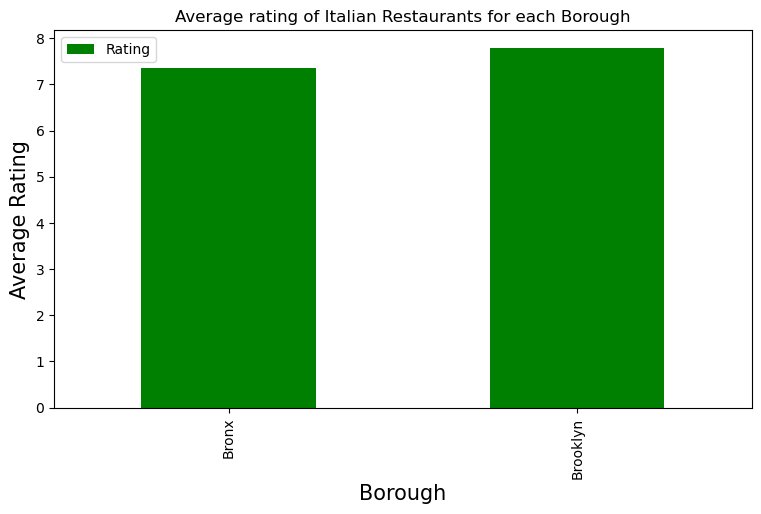

In [38]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Italian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

As we can only have 50 calls per daya we only got data for bronx and brooklyn

In [39]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bay Ridge,7.075000
1,Bedford Park,7.800000
2,Bedford Stuyvesant,9.100000
3,Belmont,8.029412
4,Bensonhurst,7.750000
6,Bushwick,9.300000
7,Carroll Gardens,7.700000
8,City Island,8.300000
9,Cobble Hill,8.466667
13,Gravesend,7.900000


In [40]:
#We will join this Dataset to original New York data to get longitude and latitude
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,7.075000
1,Bronx,Bedford Park,40.870185,-73.885512,7.800000
2,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,9.100000
3,Bronx,Belmont,40.857277,-73.888452,8.029412
4,Brooklyn,Bensonhurst,40.611009,-73.995180,7.750000
5,Brooklyn,Bushwick,40.698116,-73.925258,9.300000
6,Brooklyn,Carroll Gardens,40.680540,-73.994654,7.700000
7,Bronx,City Island,40.847247,-73.786488,8.300000
8,Brooklyn,Cobble Hill,40.687920,-73.998561,8.466667
9,Brooklyn,Gravesend,40.595260,-73.973471,7.900000


In [41]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [42]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

Among the Bronx and Brooklyn boroughs, Bushwick has the best rated italian restaurant. However, Manhattan has the highest number of italian restauarants despite having less number of neighborhoods. Based on the above information, Brooklyn would be the best place to have the restauranta. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.